In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Part 1 — Non-Linear Regression

In this section, we study the behavior of polynomial regression and ridge regularization when fitting a non-linear function.  
We will examine how different values of the regularization parameter λ affect model generalization, especially under a Leave-One-Out Cross-Validation (LOOCV) evaluation.

### Generating the Dataset

We generate **25 data points** using the function:

\[
y = sin(5 𝜋 xi) + 𝜀!
\]

where:
- \( x  ∈ (0, 1) \)
- \( 𝜀! ∈ (-0.3, 0.3) \)

We then build polynomial features up to degree 9, producing:

\[
X = [1, x, x^2, ..., x^9]
\]

Finally, we hold out **5 examples** as a final **test set**, leaving **20 examples** for training and cross-validation.

In [2]:
np.random.seed(12)

n = 25
degree = 9

x = np.random.rand(n)  
eps = np.random.uniform(-0.3, 0.3, n)

y = np.sin(5 * np.pi * x) + eps
X = np.column_stack([x**k for k in range(degree + 1)])

X_temp, X_test, y_temp, y_test, x_temp, x_test = train_test_split(
    X, y, x, test_size=5, random_state=2)

X_temp.shape, X_test.shape

((20, 10), (5, 10))

### Leave-One-Out Cross-Validation (LOOCV)

Since our dataset is very small, using a traditional train/validation split would be unreliable because the validation set may end up being too noisy.
Instead, for each value of λ, we perform LOOCV on the 20 non-test points:

1. Leave out one point for validation  
2. Train on the remaining 19  
3. Compute the squared error on the held-out point  
4. Repeat for all 20 points  
5. Average the validation errors to obtain the LOOCV error for that λ  

This process provides a more stable and unbiased estimate of model performance.

In [3]:
lambdas = [0, 0.01, 0.1, 1, 10]
cv_errors = {}

X_cv = X_temp
y_cv = y_temp
x_cv = x_temp

for lam in lambdas:
    errors = []

    for i in range(len(X_cv)):
        X_train = np.delete(X_cv, i, axis=0)
        y_train = np.delete(y_cv, i, axis=0)

        X_val = X_cv[i].reshape(1, -1)
        y_val = y_cv[i]

        model = Ridge(alpha=lam, fit_intercept=False)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        errors.append((y_val - y_pred[0])**2)

    cv_errors[lam] = np.mean(errors)

cv_errors

{0: 0.10212678629747525,
 0.01: 0.5465026391383596,
 0.1: 0.5142342356921767,
 1: 0.500844829481731,
 10: 0.5079664108017389}

### Selecting the Best Regularization Parameter λ

We compute CV_MSE for each tested value of λ.  
The λ with the lowest LOOCV error is chosen as the **optimal regularization strength**.

In [4]:
best_lambda = min(cv_errors, key=cv_errors.get)
best_lambda

0

### Training the Final Model

Using the best λ from LOOCV, we refit the model on all 20 training set examples.  
This gives the model the maximum amount of training data while still preserving an unbiased estimate of λ.

In [5]:
final_model = Ridge(alpha=best_lambda, fit_intercept=False)
final_model.fit(X_cv, y_cv)

,alpha,0
,fit_intercept,False
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


### Evaluating on the Testing Set

We now evaluate the chosen model on the 5 completely unseen test examples.  
This provides the **true generalization error** of our final model.

In [6]:
y_pred_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mse

0.057104372921949344

### Plotting the Polynomial Fits for Different λ

Here we visualize how the ridge regression model behaves for different λ values.  
- Small λ → flexible, wiggly curves (risk of overfitting)  
- Large λ → smoother, more biased curves  

The plot overlays:
- The 20 training examples (blue)
- The 5 testing examples (red)
- The fitted curves for each λ

This allows us to visually compare model smoothness and stability.

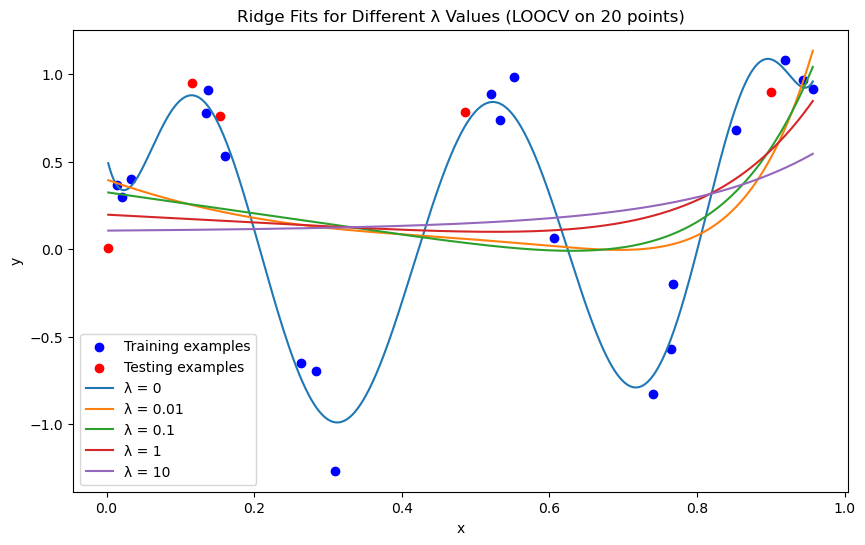

In [9]:
plt.figure(figsize=(10,6))

plt.scatter(x_cv, y_cv, color='blue', label='Training examples')
plt.scatter(x_test, y_test, color='red', label='Testing examples')

grid = np.linspace(x.min(), x.max(), 600)
X_grid = np.column_stack([grid**k for k in range(degree + 1)])

for lam in lambdas:
    model = Ridge(alpha=lam, fit_intercept=False)
    model.fit(X_cv, y_cv)
    y_pred_grid = model.predict(X_grid)
    plt.plot(grid, y_pred_grid, label=f"λ = {lam}")

plt.title("Ridge Fits for Different λ Values (LOOCV on 20 points)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Summary of Results

We print:

- The LOOCV MSE for each λ  
- The selected best λ  
- The final test MSE  

These values allow us to quantify:
- How each λ performed during cross-validation  
- How well the chosen model generalizes to new data  

In [10]:
print("LOOCV Errors:")
for lam, err in cv_errors.items():
    print(f"lambda = {lam:<5}   CV MSE = {err:.6f}")

print("\nBest lambda:", best_lambda)
print("Final Test MSE:", test_mse)

LOOCV Errors:
lambda = 0       CV MSE = 0.102127
lambda = 0.01    CV MSE = 0.546503
lambda = 0.1     CV MSE = 0.514234
lambda = 1       CV MSE = 0.500845
lambda = 10      CV MSE = 0.507966

Best lambda: 0
Final Test MSE: 0.057104372921949344
